# Transfer learning on the OPU

## Computing the convolutional features

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

<style>.container { width:80% !important; }</style>
### Dataset: STL10

The STL10 dataset is already downloaded on our servers. It can be loaded with any of your favorite frameworks from `<ml_data_path>/STL10`. It's a dataset for image classification that consists in 5k training and 8k test examples. There are also 100k unlabelled ones. The images are RGB with size 96x96 and there are 10 classes.

In [2]:
# Data preparation
from lightonml.utils import get_ml_data_dir_path
normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                normalize
                                ])
data_path = str(get_ml_data_dir_path() / "STL10")
train_data = datasets.STL10(root=data_path, split='train', transform=transform, download=True)
test_data = datasets.STL10(root=data_path, split='test', transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=12, drop_last=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=12, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


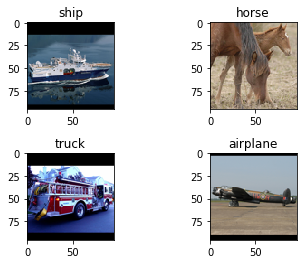

In [3]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(np.transpose(train_data.data[9], (1, 2, 0)))
axarr[0, 0].set_title(train_data.classes[train_data.labels[9]])
axarr[0, 1].imshow(np.transpose(train_data.data[15], (1, 2, 0)))
axarr[0, 1].set_title(train_data.classes[train_data.labels[15]])
axarr[1, 0].imshow(np.transpose(train_data.data[5], (1, 2, 0)))
axarr[1, 0].set_title(train_data.classes[train_data.labels[5]])
axarr[1, 1].imshow(np.transpose(train_data.data[10], (1, 2, 0)))
axarr[1, 1].set_title(train_data.classes[train_data.labels[10]])
f.subplots_adjust(hspace=0.5)

### Model VGG16

Details about this architecture are in the following paper:

*Very Deep Convolutional Networks for Large-Scale Image Recognition*,
K. Simonyan, A. Zisserman,
arXiv:1409.1556

We extract the features from the last convolutional layer.

Example of a VGG architecture

In [4]:
use_cuda = torch.cuda.is_available()

def compute_features(loader, model):
    model.eval()
    conv_features = []
    labels = []
    for i, (images, targets) in enumerate(loader):
        if use_cuda:
            images = Variable(images.cuda())
        else:
            images = Variable(images)

        outputs = model.features(images)
        conv_features.append(outputs.data.cpu().view(images.size(0), -1).numpy())
        labels.append(targets.numpy())
    return np.concatenate(conv_features), np.concatenate(labels)

In [5]:
# Load the model
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()
# Move model to GPU
if use_cuda:
    vgg16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/iacolippo/.cache/torch/checkpoints/vgg16-397923af.pth


In [6]:
%%time
train_conv_features, train_labels = compute_features(train_loader, vgg16)
test_conv_features, test_labels = compute_features(test_loader, vgg16)

np.savez_compressed('conv_features.npz', train=train_conv_features, test=test_conv_features)
np.savez_compressed('labels.npz', train=train_labels, test=test_labels)

CPU times: user 33.4 s, sys: 7.02 s, total: 40.4 s
Wall time: 41 s


## Learning a new classifier

In [7]:
from sklearn.linear_model import RidgeClassifier

from lightonml.encoding.base import Float32Encoder, MixingBitPlanDecoder
from lightonml.projections.sklearn import OPUMap

### Load data

In [8]:
conv_features = np.load('conv_features.npz')
labels = np.load('labels.npz')

n_components = 315000

train_conv_features = conv_features['train']
test_conv_features = conv_features['test']
train_labels = labels['train']
test_labels = labels['test']

### OPU Pipeline

We encode the data in a binary format using the `Float32Encoder` and keeping the first 2 bits of the exponent. We project these features to a much higher dimensional space (size = $315000$). We decode the result using the `MixingBitPlanDecoder` and we learn a linear classifier (`RidgeClassifier`) on the random features.

In [9]:
encoder = Float32Encoder(sign_bit=False, exp_bits=2, mantissa_bits=0)
since = time.time()
encoder.fit(train_conv_features)
encoded_conv_train_features = encoder.transform(train_conv_features)
encoder.fit(test_conv_features)
encoded_conv_test_features = encoder.transform(test_conv_features)
encoding_time = time.time() - since
print('Time for encoding: {:.4f} s'.format(encoding_time))

Time for encoding: 5.8901 s


In [10]:
since = time.time()
opu_mapping = OPUMap(n_components=n_components)
train_random_features = opu_mapping.transform(encoded_conv_train_features)
test_random_features = opu_mapping.transform(encoded_conv_test_features)
projection_time = time.time() - since
print('Time taken by RP on OPU: {:.4f} s'.format(projection_time))

Time taken by RP on OPU: 20.3247 s


In [11]:
decoder = MixingBitPlanDecoder(n_bits=2)
since = time.time()
decoder.fit(train_random_features)
train_random_features = decoder.transform(train_random_features)
decoder.fit(test_random_features)
test_random_features = decoder.transform(test_random_features)
decoding_time = time.time() - since
print('Time for decoding: {:.4f} s'.format(decoding_time))

Time for decoding: 1.7091 s


In [12]:
clf = RidgeClassifier(alpha=10)
since = time.time()
clf.fit(train_random_features, train_labels)
fit_time = time.time() - since
print('Time for fit: {:.4f} s'.format(fit_time))

Time for fit: 29.9856 s


## Model score

In [13]:
since = time.time()
train_accuracy = clf.score(train_random_features, train_labels)
test_accuracy = clf.score(test_random_features, test_labels)
score_time = time.time() - since
print('Time for score: {:.4f} s'.format(score_time))
print('OPU Train accuracy (%): {:.4f}'.format(train_accuracy*100))
print('OPU Test accuracy (%): {:.4f}'.format(test_accuracy*100))
print('Total time: {:.4f} s'.format(encoding_time + projection_time + decoding_time + fit_time + score_time))

Time for score: 3.4853 s
OPU Train accuracy (%): 100.0000
OPU Test accuracy (%): 91.6500
Total time: 61.3948 s
